# Bagging

In [143]:
from preprocessing import *
from aux import *
import matplotlib
#np.warnings.filterwarnings('ignore')

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import BaggingClassifier

sns.set()

df_data = pd.read_csv('https://drive.google.com/uc?export=download&id=1i-KJ2lSvM7OQH0Yd59bX01VoZcq8Sglq')
df_decision = pd.read_csv('https://drive.google.com/uc?export=download&id=1km-AEIMnWVGqMtK-W28n59hqS5Kufhd0')

## Preprocesado 1

In [144]:
columnillas = ['tipo_de_sala_4d', 'tipo_de_sala_normal', 'tipo_de_sala_nan', 'id_usuario', 'genero_mujer', 'genero_nan', 
              'edad', 'amigos', 'parientes', 
              'nombre_sede_fiumark_palermo', 'nombre_sede_fiumark_quilmes', 'nombre_sede_nan']

In [145]:
def preprocesado_1(dataset, columnas):
    df = eliminar_features_que_no_aportan_info(dataset, True)
    df = eliminar_features(df, ['precio_ticket'])
    df = replace_nulls_column(df, 'edad', 'mediana')
    columnas_a_encodear = ['tipo_de_sala', 'genero', 'nombre_sede']
    df = encodear_atributos_categoricos(df, columnas_a_encodear)
    df = df.reindex(columns = columnas)
    return df

In [146]:
volver = ['volveria']
columnas = columnillas + volver

In [147]:
dataset = pd.merge(df_data, df_decision, how='inner', left_on='id_usuario', right_on='id_usuario')

df = preprocesado_1(dataset, columnas)

df.head()

,tipo_de_sala_4d,tipo_de_sala_normal,tipo_de_sala_nan,id_usuario,genero_mujer,genero_nan,edad,amigos,parientes,nombre_sede_fiumark_palermo,nombre_sede_fiumark_quilmes,nombre_sede_nan,volveria
0,1,0,0,117,0,0,73.5,0,0,0,1,0,0
1,1,0,0,658,1,0,35.0,1,1,0,1,0,0
2,0,1,0,794,0,0,31.0,0,0,0,0,0,0
3,1,0,0,455,0,0,31.0,0,0,1,0,0,0
4,1,0,0,173,1,0,4.0,1,1,1,0,0,1


In [148]:
df.shape

(801, 13)

# Entrenamiento

In [149]:
X, y = split_dataset_X_y(df, columnillas)

params = {'max_samples': np.arange(1, 50), 
          'max_features': np.arange(1, 12),
          'n_estimators': np.arange(1, 50),
         }

model_bagging = BaggingClassifier(
    base_estimator = DecisionTreeClassifier(max_depth=3, min_samples_leaf=10,random_state=117, criterion="entropy"),
    random_state = 117
)

best_params, X_train, X_test, y_train, y_test = fit_model_random_grid_search (X, y, model_bagging, params)

bagging = BaggingClassifier(
    base_estimator = DecisionTreeClassifier(max_depth=3, min_samples_leaf=10,random_state=117,criterion="entropy"),
    random_state=117,
    n_estimators = best_params['n_estimators'],
    max_samples = best_params['max_samples'],
    max_features = best_params['max_features']
)

bagging = apply_stratified_k_fold(X, y, bagging)

X.shape:  (801, 12)
y.shape:  (801,) 

Best score: 0.8502937720329026
Best params {'n_estimators': 46, 'max_samples': 27, 'max_features': 11}

Fold 0: AUC ROC score is 0.7208
Fold 1: AUC ROC score is 0.7062
Fold 2: AUC ROC score is 0.7881
Fold 3: AUC ROC score is 0.7351
Fold 4: AUC ROC score is 0.7288
Mean test AUC ROC is: 0.7358


In [150]:
X.head()

,tipo_de_sala_4d,tipo_de_sala_normal,tipo_de_sala_nan,id_usuario,genero_mujer,genero_nan,edad,amigos,parientes,nombre_sede_fiumark_palermo,nombre_sede_fiumark_quilmes,nombre_sede_nan
0,1,0,0,117,0,0,73.5,0,0,0,1,0
1,1,0,0,658,1,0,35.0,1,1,0,1,0
2,0,1,0,794,0,0,31.0,0,0,0,0,0
3,1,0,0,455,0,0,31.0,0,0,1,0,0
4,1,0,0,173,1,0,4.0,1,1,1,0,0


In [151]:
y.head()

0    0
1    0
2    0
3    0
4    1
Name: volveria, dtype: int64

In [152]:
y.sum()

307

In [153]:
y_train.value_counts()

0    370
1    230
Name: volveria, dtype: int64

In [154]:
y_test.value_counts()

0    124
1     77
Name: volveria, dtype: int64

## Métricas

In [155]:
scores = get_scores(bagging, X_test, y_test)

AUC ROC : 0.8027
Accuracy : 0.7811
Precision : 1.0000
Recall : 1.0000
F1-Score : 0.6000


### Matriz de confusión

/home/anarella/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[0, 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


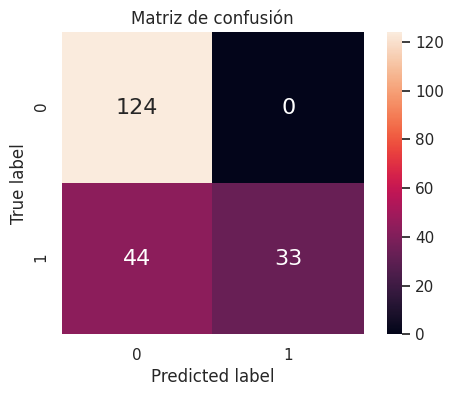

In [156]:
plot_confusion_matrix(y_test, bagging.predict(X_test))

## Test Holdout

In [157]:
holdout = pd.read_csv('https://drive.google.com/uc?export=download&id=1I980-_K9iOucJO26SG5_M8RELOQ5VB6A')

In [158]:
df_h = preprocesado_1(holdout, columnillas)
df_h.head()

,tipo_de_sala_4d,tipo_de_sala_normal,tipo_de_sala_nan,id_usuario,genero_mujer,genero_nan,edad,amigos,parientes,nombre_sede_fiumark_palermo,nombre_sede_fiumark_quilmes,nombre_sede_nan
0,1,0,0,650,1,0,26.0,0,0,1,0,0
1,1,0,0,234,1,0,8.0,4,2,1,0,0
2,0,1,0,31,0,0,43.0,0,0,0,0,0
3,0,0,0,552,0,0,30.0,0,0,1,0,0
4,1,0,0,411,0,0,32.0,0,0,1,0,0


In [159]:
df_resultado = evaluate_holdout(holdout, df_h, bagging)
df_resultado.head(15)

y_pred.shape:  (90,)
holdout_df.shape:  (90, 12) 



,id_usuario,volveria
0,650,0
1,234,0
2,31,0
3,552,0
4,411,0
5,134,1
6,497,1
7,434,0
8,528,0
9,112,0


In [160]:
df_resultado.to_csv('prediccion/Bagging_resultado_final.csv')

## Preprocesado 2

In [215]:
columnas_nuevas = ['tipo_de_sala_4d', 'tipo_de_sala_normal', 'tipo_de_sala_nan', 'id_usuario', 'genero_mujer', 'genero_nan', 
              'edad', 'precio_ticket', 'amigos',
              'nombre_sede_fiumark_palermo', 'nombre_sede_fiumark_quilmes', 'nombre_sede_nan', 
              'cant_acompañantes']

In [216]:
def preprocesado_2(dataset, columnas):
    df = eliminar_features_que_no_aportan_info(dataset, True)
    df = crear_feature_acompañantes(df)
    df = eliminar_features(df, ['parientes'])
    df = replace_nulls_column(df, 'edad', 'mediana')
    columnas_a_encodear = ['tipo_de_sala', 'genero', 'nombre_sede']
    df = encodear_atributos_categoricos(df, columnas_a_encodear)
    df = normalizar_atributos_numericos(df)
    df = df.reindex(columns = columnas)
    return df

In [217]:
columnas_2 = columnas_nuevas + volver

In [218]:
df_2 = preprocesado_2(dataset, columnas_2)

df_2.head()

,tipo_de_sala_4d,tipo_de_sala_normal,tipo_de_sala_nan,id_usuario,genero_mujer,genero_nan,edad,precio_ticket,amigos,nombre_sede_fiumark_palermo,nombre_sede_fiumark_quilmes,nombre_sede_nan,cant_acompañantes,volveria
0,1,0,0,0.130337,0,0,0.880653,0.000000,0.000,0,1,0,0.0,0.0
1,1,0,0,0.738202,1,0,0.396985,0.020408,0.125,0,1,0,0.2,0.0
2,0,1,0,0.891011,0,0,0.346734,0.040816,0.000,0,0,0,0.0,0.0
3,1,0,0,0.510112,0,0,0.346734,0.000000,0.000,1,0,0,0.0,0.0
4,1,0,0,0.193258,1,0,0.007538,0.020408,0.125,1,0,0,0.2,1.0


In [219]:
df_2.shape

(801, 14)

# Entrenamiento

In [220]:
X_2, y_2 = split_dataset_X_y(df_2, columnas_nuevas)

model_bagging = BaggingClassifier(
    base_estimator = DecisionTreeClassifier(max_depth=3, min_samples_leaf=10,random_state=117, criterion="entropy"),
    random_state = 117
)
params_2 = {'max_samples': np.arange(1, 50), 
          'max_features': np.arange(1, 10),
          'n_estimators': np.arange(1, 50),
         }
best_params_2, X_train_2, X_test_2, y_train_2, y_test_2 = fit_model_random_grid_search (X_2, y_2, model_bagging,
                                                                                        params_2)

bagging_2 = BaggingClassifier(
    base_estimator = DecisionTreeClassifier(max_depth=3, min_samples_leaf=10,random_state=117,criterion="entropy"),
    random_state=117,
    n_estimators = best_params_2['n_estimators'],
    max_samples = best_params_2['max_samples'],
    max_features = best_params_2['max_features']
)

bagging_2 = apply_stratified_k_fold(X_2, y_2, bagging_2)

X.shape:  (801, 13)
y.shape:  (801,) 

Best score: 0.8509106933019976
Best params {'n_estimators': 34, 'max_samples': 48, 'max_features': 7}

Fold 0: AUC ROC score is 0.7519
Fold 1: AUC ROC score is 0.7414
Fold 2: AUC ROC score is 0.7938
Fold 3: AUC ROC score is 0.7370
Fold 4: AUC ROC score is 0.7503
Mean test AUC ROC is: 0.7549


## Métricas

In [221]:
scores_2 = get_scores(bagging_2, X_test_2, y_test_2)

AUC ROC : 0.8218
Accuracy : 0.7264
Precision : 0.6618
Recall : 0.8145
F1-Score : 0.6207


### Matriz de confusión

/home/anarella/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[0.0, 1.0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


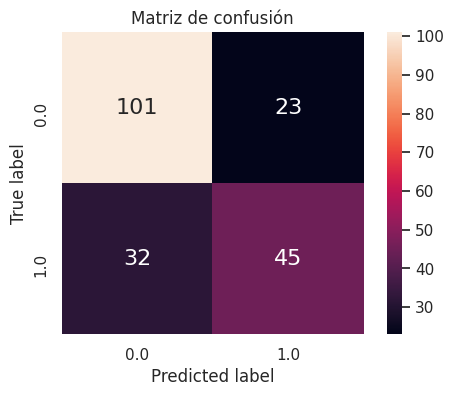

In [222]:
plot_confusion_matrix(y_test_2, bagging_2.predict(X_test_2))

## Test Holdout

In [223]:
df_h_2 = preprocesado_2(holdout, columnas_nuevas)
df_h_2.head()

,tipo_de_sala_4d,tipo_de_sala_normal,tipo_de_sala_nan,id_usuario,genero_mujer,genero_nan,edad,precio_ticket,amigos,nombre_sede_fiumark_palermo,nombre_sede_fiumark_quilmes,nombre_sede_nan,cant_acompañantes
0,1,0,0,0.751756,1,0,0.344774,0.000000,0.0,1,0,0,0.0
1,1,0,0,0.264637,1,0,0.063963,0.061224,0.5,1,0,0,0.6
2,0,1,0,0.026932,0,0,0.609984,0.040816,0.0,0,0,0,0.0
3,0,0,0,0.637002,0,0,0.407176,0.040816,0.0,1,0,0,0.0
4,1,0,0,0.471897,0,0,0.438378,0.000000,0.0,1,0,0,0.0


In [224]:
df_resultado_2 = evaluate_holdout(holdout, df_h_2, bagging_2)
df_resultado_2.head(15)

y_pred.shape:  (90,)
holdout_df.shape:  (90, 13) 



,id_usuario,volveria
0,650,0
1,234,1
2,31,0
3,552,0
4,411,0
5,134,1
6,497,1
7,434,0
8,528,0
9,112,1


In [225]:
df_resultado_2.to_csv('prediccion/Bagging_2do_prepoc_resultado_final.csv')